# 🏡 Анализ рынка недвижимости Мельбурна

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from matplotlib.gridspec import GridSpec
from sklearn.datasets import load_iris

# Цель проекта
___
Нам нужно понять, какие факторы больше всего влияют на стоимость недвижимости — в частности интересует площадь, расположение, и базовые характеристики дома. Особенно важно понять, как цена зависит от района и расстояния до центра города. Если есть аномальные данные — убрать их. В идеале хотелось бы получить список перспективных районов и пригородов, где можно выгодно инвестировать. Сформулировать рекомендации для маркетинга: где можно позиционировать жильё как бизнес-класс. Сделать пошаговое исследование с пояснениями на каждом этапе. 
___

## Вопросы: 
- 1. Как устроен датасет? Какие переменные присутствуют?
- 2. Насколько данные корректны? Есть ли ошибки формата?
- 3. Какие признаки имеют пропуски? Что можно восстановить?
- 4. Какие фичи можно добавить для улучшения анализа?
- 5. Как распределены ключевые параметры? Есть ли перекосы?
- 6. Есть ли аномалии и шум? Как они влияют на выводы?
- 7. Какие признаки сильнее всего влияют на цену?
- 8. Какие районы самые дорогие? Где можно выгодно инвестировать?
- 9. Какие выводы можно сделать? Что порекомендовать бизнесу?

## Краткий план:
- 01. Загрузка данных и быстрый взгляд
- 02. Приведение типов, базовая чистка
- 03. Анализ пропусков, заполнение
- 04. Создание вспомогательных фичей
- 05. Базовые описательные статистики (Stage 2)
- 06. Выбросы: диагностика и фильтрация
- 07. Корреляции и scatterplots (Stage 3, уже на очищенных данных)
- 08. Локальный анализ по пригородам/регионам (Stage 4)
- 09. Финальные выводы и гипотезы (Stage 5, текстом)

## 01. Загрузка данных и быстрый взгляд
 _Отвечает на вопрос №1: Как устроен датасет? Какие переменные присутствуют?_

In [2]:
# улучшаем читаемость данных
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
# делаем единый стиль графиков
sns.set(style='whitegrid', context='notebook')

In [5]:
# df_houses = pd.read_csv('/Users/vladislavlipkin/Downloads/melb_data.csv') # MAC OS
df_houses = pd.read_csv(r'C:\Users\Incognitus\Downloads\melb_data.csv') # WINDOWS

In [6]:
# df_houses.head(10)
# df_houses.shape
df_houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

## Расшифровка заданных полей в таблице 
- Suburb - Пригород (район в Мельбурне)
- Address - Адрес недвижимости
- Rooms - Количество комнат
- Type - Тип недвижимости (например, дом, квартира и т.п.)
- Price - Цена продажи
- Method - Метод продажи (например, аукцион, частная продажа)
- SellerG - Название агентства-продавца
- Date - Дата продажи
- Distance - Расстояние до центра Мельбурна (в км)
- Postcode - Почтовый индекс
- Bedroom2 - Количество спален (иногда совпадает с Rooms)
- Bathroom - Количество ванных комнат
- Car - Количество парковочных мест
- Landsize - Размер участка (в м²)
- BuildingArea - Площадь здания (в м²)
- YearBuilt - Год постройки
- CouncilArea - Муниципальный округ / район
- Lattitude - Широта (геокоордината)
- Longtitude - Долгота (геокоордината)
- Regionname - Название региона (например, “Southern Metropolitan”)
- Propertycount - Количество объектов недвижимости в районе

In [7]:
# просмотр таблицы , топ 5 дорогих объектов
df_houses.sort_values(by='Price', ascending=False).head(5)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
12094,Mulgrave,35 Bevis St,3,h,"9,000,000.00",PI,Hall,29/07/2017,18.80,"3,170.00",...,1.00,1.00,744.00,117.00,"1,960.00",Monash,-37.93,145.16,South-Eastern Metropolitan,"7,113.00"
7692,Canterbury,49 Mangarra Rd,5,h,"8,000,000.00",VB,Sotheby's,13/05/2017,9.00,"3,126.00",...,5.00,4.00,"2,079.00",464.30,"1,880.00",Boroondara,-37.82,145.07,Southern Metropolitan,"3,265.00"
9575,Hawthorn,49 Lisson Gr,4,h,"7,650,000.00",S,Abercromby's,17/06/2017,5.30,"3,122.00",...,2.00,4.00,"1,690.00",284.00,"1,863.00",Boroondara,-37.83,145.03,Southern Metropolitan,"11,308.00"
3616,Kew,15 Barry St,6,h,"6,500,000.00",S,Jellis,13/08/2016,5.60,"3,101.00",...,6.00,3.00,"1,334.00",365.00,"1,890.00",Boroondara,-37.80,145.03,Southern Metropolitan,"10,331.00"
12557,Middle Park,136 Page St,5,h,"6,400,000.00",S,Marshall,9/09/2017,3.00,"3,206.00",...,2.00,1.00,553.00,308.00,"1,920.00",NaN,-37.85,144.96,Southern Metropolitan,"2,019.00"


## 02. Приведение типов, базовая чистка  
 _Отвечает на вопрос №2: Насколько данные корректны? Есть ли ошибки формата?_

In [9]:
# преобразовываем дату
df_houses['Date'] = pd.to_datetime(df_houses['Date'], format='%d/%m/%Y', errors='coerce')

# Строковые категории — в category (экономит память, удобнее группировать)
cat_cols = ['Suburb', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname', 'Postcode']
for c in cat_cols:
    if c in df_houses.columns:
        df_houses[c] = df_houses[c].astype('category')

# Создадим копию сырых данных
df_raw = df_houses.copy()

## 03. Анализ пропусков, заполнение
 _Отвечает на вопрос №3: Какие признаки имеют пропуски? Что можно восстановить?_

In [11]:
# найти пропущенные строки
df_houses.isnull().sum().sort_values(ascending=False)

BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Car                62
Suburb              0
Bathroom            0
Regionname          0
Longtitude          0
Lattitude           0
Landsize            0
Bedroom2            0
Address             0
Postcode            0
Distance            0
Date                0
SellerG             0
Method              0
Price               0
Type                0
Rooms               0
Propertycount       0
dtype: int64

In [12]:
#  заполнение медианой сначала в Suburb, после в оставшихся NaN общей медианой по столбцу
for col in ['BuildingArea', 'Landsize', 'YearBuilt', 'Car']:
    if col in df_houses.columns:
        # заполнение пустых ячеек по Suburb
        df_houses[col] = df_houses[col].fillna(df_houses.groupby('Suburb')[col].transform('median'))
        # страховка , заполнение по всему столбцу без группировки
        df_houses[col] = df_houses[col].fillna(df_houses[col].median())

C:\Users\Incognitus\AppData\Local\Temp\ipykernel_440\4030824298.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_houses[col] = df_houses[col].fillna(df_houses.groupby('Suburb')[col].transform('median'))


## 04. Создание вспомогательных фичей
_Отвечает на вопрос №4: Какие признаки можно добавить для улучшения анализа?_

In [14]:
# сделать столбец стоимость (Price) более читаемым
df_houses['price_mln'] = df_houses['Price'] / 1_000_000
# бины по расстоянию для BOXPLOT
df_houses['Distance_bin'] = pd.qcut(df_houses['Distance'], q=5, duplicates='drop')

## 05. Базовые описательные статистики (Stage 2)
_Отвечает на вопрос №5: Как распределены ключевые параметры? Есть ли перекосы?_
### Средняя/медианная цена по регионам/пригородам/типам и т.д.

### 05.1 — медиана по Regionname

In [16]:
price_region = (
    df_houses.groupby('Regionname')['Price']
    .median()
    .sort_values(ascending=False)
    .rename('median_price')
    .reset_index()
)

price_region['median_price_mln'] = price_region['median_price'] / 1_000_000
price_region

C:\Users\Incognitus\AppData\Local\Temp\ipykernel_440\1853917866.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_houses.groupby('Regionname')['Price']


,Regionname,median_price,median_price_mln
0,Southern Metropolitan,"1,250,000.00",1.25
1,Eastern Metropolitan,"1,010,000.00",1.01
2,South-Eastern Metropolitan,"850,000.00",0.85
3,Northern Metropolitan,"806,250.00",0.81
4,Western Metropolitan,"793,000.00",0.79
5,Eastern Victoria,"670,000.00",0.67
6,Northern Victoria,"540,000.00",0.54
7,Western Victoria,"400,000.00",0.40


### 05.2 — топ-10 пригородов по медианной цене

In [17]:
price_suburb = (
    df_houses.groupby('Suburb')['Price']
    .median()
    .sort_values(ascending=False)
    .rename('median_price')
    .reset_index()
)
top10_suburbs = price_suburb.head(10)
top10_suburbs

C:\Users\Incognitus\AppData\Local\Temp\ipykernel_440\4138098678.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_houses.groupby('Suburb')['Price']


,Suburb,median_price
0,Kooyong,"2,185,000.00"
1,Eaglemont,"1,901,000.00"
2,Albert Park,"1,900,000.00"
3,Canterbury,"1,890,000.00"
4,Middle Park,"1,880,000.00"
5,Balwyn,"1,850,000.00"
6,Brighton,"1,773,500.00"
7,Kew East,"1,750,000.00"
8,Ivanhoe East,"1,740,000.00"
9,Balwyn North,"1,739,000.00"


### 05.3. Визуализации распределений/boxplot
### Создаём фигуру с тремя подграфиками в одном ряду

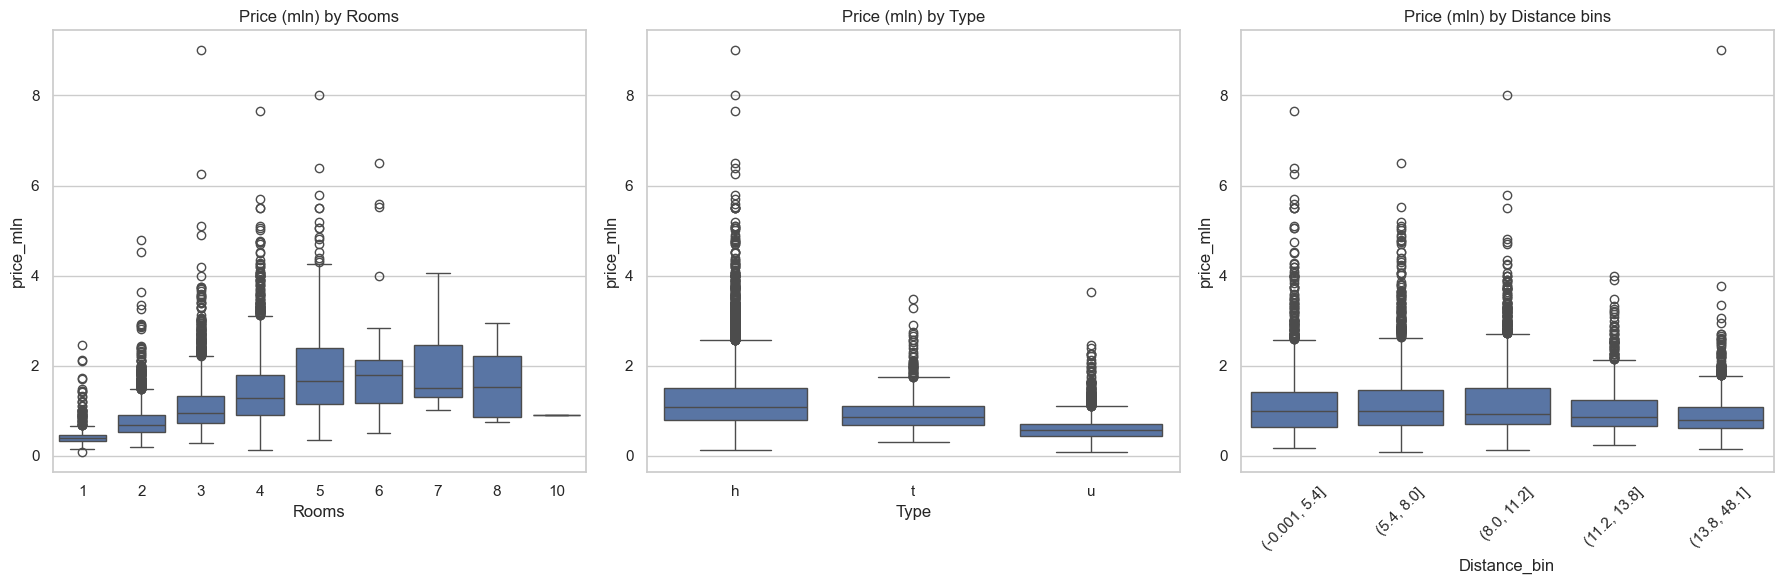

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 05.3a — Boxplot: Price vs Rooms
sns.boxplot(data=df_houses, x='Rooms', y='price_mln', ax=axes[0])
axes[0].set_title('Price (mln) by Rooms')

# 05.3b — Boxplot: Price vs Type
sns.boxplot(data=df_houses, x='Type', y='price_mln', ax=axes[1])
axes[1].set_title('Price (mln) by Type')

# 05.3c — Boxplot: Price vs Distance bins
sns.boxplot(data=df_houses, x='Distance_bin', y='price_mln', ax=axes[2])
axes[2].set_title('Price (mln) by Distance bins')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()

## 06. Выбросы: диагностика и фильтрация
_Отвечает на вопрос №6: Есть ли аномалии и шум? Как они влияют на выводы?_

### 06.1 — функция для подсчёта выбросов

In [20]:
def count_outliers_iqr(series):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    return ((series < low) | (series > high)).sum()

print('Выбросы по полю Rooms')
print(df_houses.groupby('Rooms')['Price'].apply(count_outliers_iqr))
print('')
print('Выбросы по полю Type')
print(df_houses.groupby('Type')['Price'].apply(count_outliers_iqr))

Выбросы по полю Rooms
Rooms
1      52
2     149
3     173
4      95
5      15
6       4
7       0
8       0
10      0
Name: Price, dtype: int64

Выбросы по полю Type
Type
h    430
t     43
u    127
Name: Price, dtype: int64


C:\Users\Incognitus\AppData\Local\Temp\ipykernel_440\1105255076.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_houses.groupby('Type')['Price'].apply(count_outliers_iqr))


### 06.2 — фильтруем “физически невозможные” и явные ошибки:

In [22]:
# BuildingArea > 0, < 1000
# Landsize > 0, BuildingArea < Landsize
# Rooms > 0
mask_valid = (
    (df_houses['BuildingArea'].gt(0) & df_houses['BuildingArea'].lt(1000)) &
    (df_houses['Landsize'].gt(0)) &
    (df_houses['BuildingArea'] < df_houses['Landsize']) &
    (df_houses['Rooms'] > 0)
)

df_clean = df_houses[mask_valid].copy()
print(f'отфильтрованный DF {df_clean.shape}') 
print(f'изначальный DF {df_houses.shape}')

отфильтрованный DF (11061, 23)
изначальный DF (13580, 23)


## 07. Корреляции и scatterplots (Stage 3, на очищенных данных)
_Отвечает на вопрос №7: Какие признаки сильнее всего влияют на цену?_

### 07.1 — корреляции
### Построение двух графиков ДО и ПОСЛЕ очистки

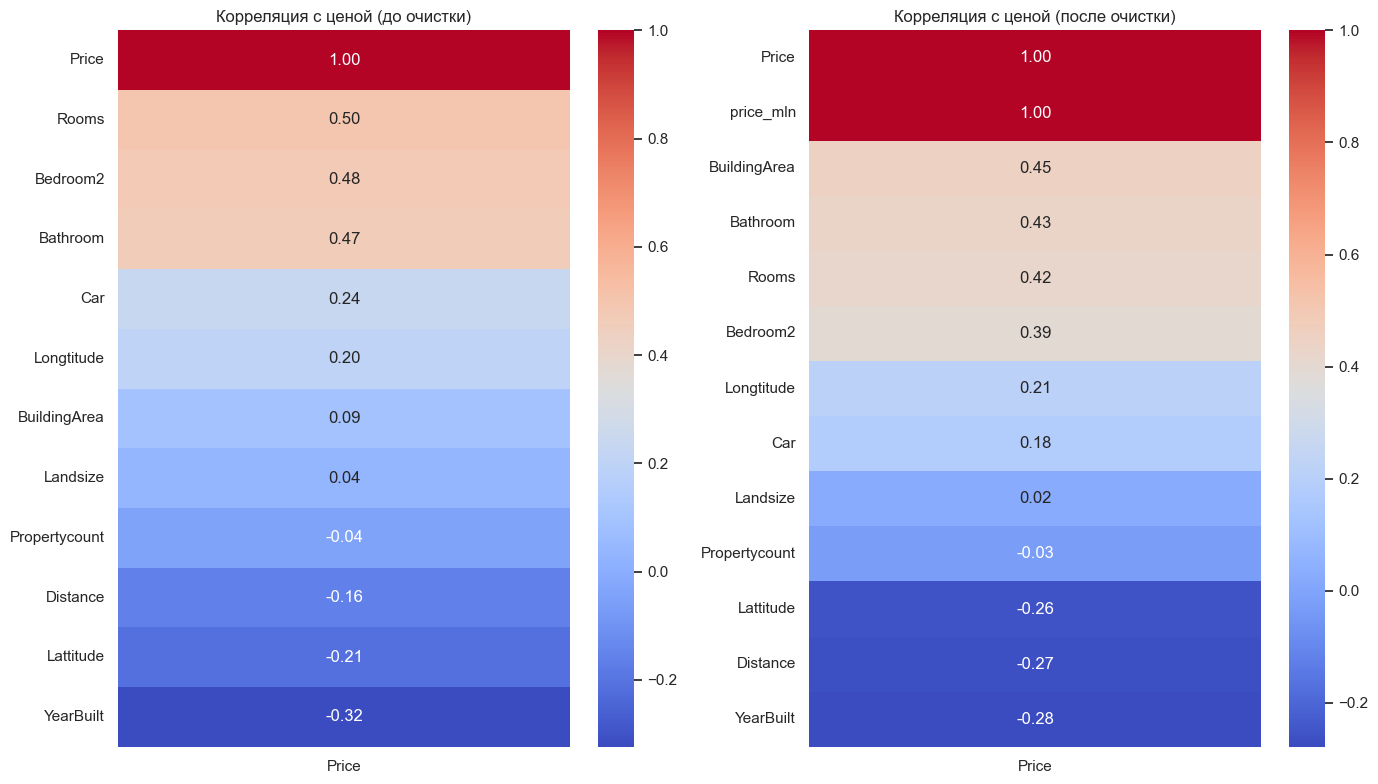

In [37]:
num_cols_raw = df_raw.select_dtypes(include=[np.number])
corr_raw = num_cols_raw.corr()

num_cols_clean = df_clean.select_dtypes(include=[np.number])
corr_clean = num_cols_clean.corr()

fig, axs = plt.subplots(1, 2, figsize=(14, 8))

# До очистки
sns.heatmap(
    corr_raw[['Price']].sort_values(by='Price', ascending=False),
    annot=True, fmt='.2f', cmap='coolwarm', ax=axs[0]
)
axs[0].set_title('Корреляция с ценой (до очистки)')

# После очистки
sns.heatmap(
    corr_clean[['Price']].sort_values(by='Price', ascending=False),
    annot=True, fmt='.2f', cmap='coolwarm', ax=axs[1]
)
axs[1].set_title('Корреляция с ценой (после очистки)')

plt.tight_layout()
plt.show()

### Создаём фигуру с тремя Scatterplot
- существуют ли визуально заметные зависимости между ценой (price_mln) и полями Distance, BuildingArea и Landsize

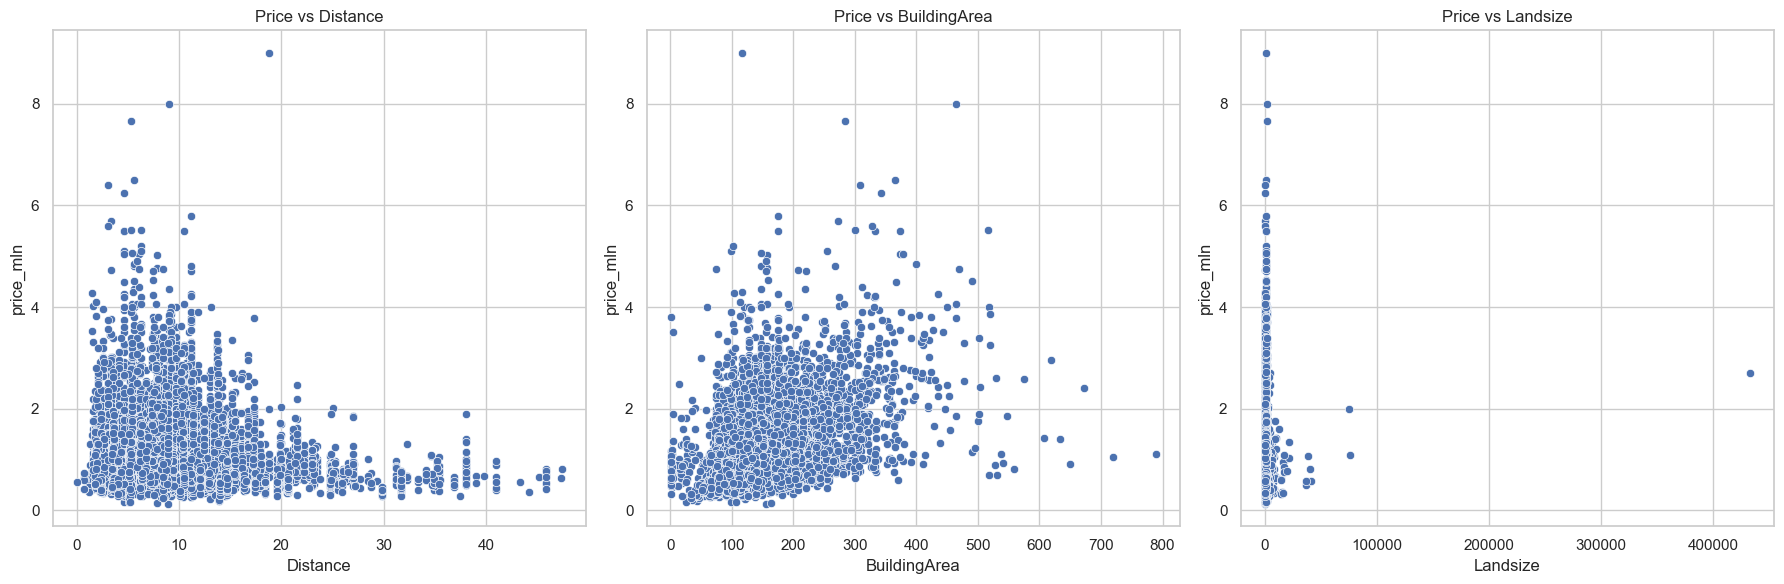

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatterplot: Price vs Distance
sns.scatterplot(data=df_clean, x='Distance', y='price_mln', ax=axes[0])
axes[0].set_title('Price vs Distance')

# Scatterplot: Price vs BuildingArea
sns.scatterplot(data=df_clean, x='BuildingArea', y='price_mln', ax=axes[1])
axes[1].set_title('Price vs BuildingArea')

# Scatterplot: Price vs Landsize
sns.scatterplot(data=df_clean, x='Landsize', y='price_mln', ax=axes[2])
axes[2].set_title('Price vs Landsize')

plt.tight_layout()

plt.show()

## 08. Локальный анализ (Stage 4)

### 08.1 — Топ-10 Suburb по медианной цене

In [43]:
top10_suburbs = (
    df_clean.groupby('Suburb')['Price']
    .median()
    .sort_values(ascending=False)
    .head(10)
)
top10_suburbs

C:\Users\Incognitus\AppData\Local\Temp\ipykernel_440\1593066948.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_clean.groupby('Suburb')['Price']


Suburb
Kooyong       3,080,000.00
Malvern       2,150,000.00
Canterbury    2,100,000.00
Balwyn        2,100,000.00
Middle Park   2,050,000.00
Toorak        2,050,000.00
Brighton      2,020,000.00
Mont Albert   1,955,000.00
Albert Park   1,950,000.00
Kew           1,950,000.00
Name: Price, dtype: float64

### 08.2 — Среднее расстояние по тем же Suburb

In [51]:
avg_distance_top10 = (
    df_clean[df_clean['Suburb'].isin(top10_suburbs.index)]
    .groupby('Suburb')['Distance']
    .mean()
)
# обьъеденение top10_suburbs и avg_distance_top10 
compare_df = pd.DataFrame({
    'median_price': top10_suburbs,
    'avg_distance': avg_distance_top10
})
compare_df['median_price_mln'] = compare_df['median_price'] / 1_000_000
compare_df.sort_values('median_price', ascending=False).head(10)

C:\Users\Incognitus\AppData\Local\Temp\ipykernel_440\2548994323.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('Suburb')['Distance']


,median_price,avg_distance,median_price_mln
Suburb,,,
Kooyong,"3,080,000.00",5.90,3.08
Middle Park,"2,410,041.67",3.73,2.41
Canterbury,"2,364,414.89",8.82,2.36
Malvern,"2,339,136.36",6.96,2.34
Toorak,"2,286,265.96",4.53,2.29
Brighton,"2,202,910.28",11.05,2.20
Kew,"2,059,977.44",5.53,2.06
East Melbourne,"2,044,166.67",1.43,2.04
Balwyn,"2,031,901.10",9.30,2.03


### 08.3 — Визуализация: Цена vs Расстояние для топ-10

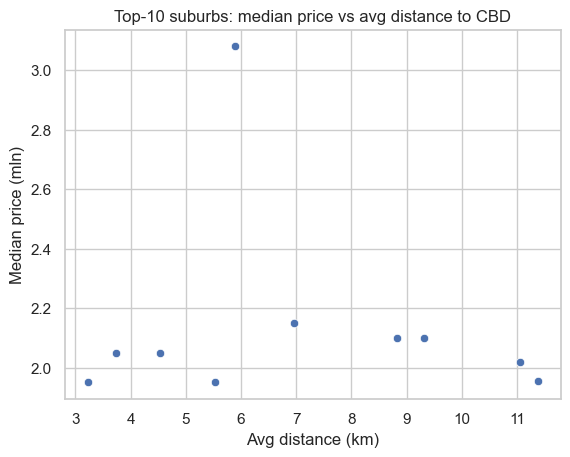

In [29]:
sns.scatterplot(data=compare_df, x='avg_distance', y='median_price_mln')
plt.title('Top-10 suburbs: median price vs avg distance to CBD')
plt.xlabel('Avg distance (km)')
plt.ylabel('Median price (mln)')
plt.show()

### 08.4 — “Дешёвые пригороды с большими участками”

In [52]:
cheap_big_land = (
    df_clean.groupby('Suburb')
    .agg(price_median=('Price', 'median'),
         landsize_median=('Landsize', 'median'))
    .sort_values(by=['price_median', 'landsize_median'], ascending=[True, False])
)

res = cheap_big_land[(cheap_big_land['landsize_median'] > 500)].head(20)
res.assign(price_mln=lambda d: d['price_median'] / 1_000_000)

C:\Users\Incognitus\AppData\Local\Temp\ipykernel_440\696445762.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_clean.groupby('Suburb')


,price_median,landsize_median,price_mln
Suburb,,,
Bacchus Marsh,"285,000.00",612.00,0.28
Rockbank,"340,000.00",609.00,0.34
Kurunjang,"353,500.00",652.50,0.35
Wallan,"366,000.00",502.00,0.37
Melton South,"390,000.00",600.50,0.39
Melton,"412,500.00",595.00,0.41
Melton West,"428,750.00",670.50,0.43
Dallas,"439,750.00",589.50,0.44
Campbellfield,"450,000.00",644.00,0.45


# 9. Финальные выводы

📌 На основе анализа можно выделить несколько ключевых наблюдений:

- Наиболее сильно с ценой недвижимости коррелируют:
  - **BuildingArea** (площадь здания),
  - **Bathroom** (кол-во ванных),
  - **Rooms** (кол-во комнат),
  - **Bedroom2** (кол-во спален),
  - **Distance** — обратная корреляция: чем ближе к центру, тем выше цена.

- Самым дорогим регионом остаётся **Southern Metropolitan**.
- Самым дешевым будет регион **Western Victoria**

  Среди пригородов — **Kooyong**, **Malvern**, **Canterbury** входят в топ по средней цене.

- В топ-10 самых дорогих пригородов в среднем наблюдается высокая близость к центру города, однако есть **исключения**, подтверждающие, 
  что фактор района также играет существенную роль.

- Если рассматривать **инвестиции** — интересны пригороды с большим средним участком (landsize > 500 м²) и невысокой ценой:  
  например, **Bacchus Marsh**, **Southbank**, **Bullengarook**.

- После очистки аномалий (неадекватные площади, нули, экстремумы)  
  **корреляция между Price и BuildingArea** усилилась:

| Сравнение            | Корреляция с BuildingArea |
|----------------------|---------------------------|
| До очистки           | ≈ 0.09                    |
| После очистки        | ≈ 0.45                    |